In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from random import choice
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
sns.set_style('darkgrid')
%matplotlib inline

# Introduction
The dataset contains 10 stores and 50 items in each store all having different observations. 
The most ideal thing to do is to analyze each store and the unique item no of interest. This prompted the building of a class method that holds several functions which can be reused on the store and item no of interest to build a time series model and perform any kind of descriptive analysis on the selected store and item. 

Also, 3 months dataset are of interest, so we would only grab our prefered 3 months of sales data and make descriptive analysis and predictions on it.

In [2]:
class TimeSeriesModel:
    #Specifies the store number, item number and any consecutive 3 months of interest in the same year.
    def __init__(self, data, f_mnth, s_mnth, t_mnth, store_no, item_no):
        df = pd.read_csv(data)
        df = df[df['date'].str.contains(f_mnth) | df['date'].str.contains(s_mnth) | df['date'].str.contains(t_mnth)].reset_index(drop=True)
        df = df.set_index('date')
        df = df[df['store'] == store_no]
        df = df[df['item'] == item_no]
        self.df = df
        self.st = store_no
        self.it = item_no
    
    #Returns the dataframe specified.
    def dataframe(self):
        return self.df
    
    #Plots the graph of the containing dataset.
    def lineplot(self, win_no ):
        df = self.df
        df_sales = df['sales']
        lis = [df_sales]
        for item in win_no:
            col_name = 'MA for %s days' %(str(item))
            df[col_name] = df['sales'].rolling(window=item).mean()
            lis.append(df[col_name])
        scale = len(lis)/2
        plt.figure(figsize=(20, 10*scale))
        x = 1
        for i in lis:
            col = '#' + ''.join([choice('0123456789ABCEDF') for j in range(6)])
            plt.subplot((len(win_no) + 1), 1, x)
            i.plot(legend=True, color=col)
            if x == 1:
                plt.title(f'Sales Trend without Moving average of store {self.st} and item {self.it}.')
            else:
                plt.title(f'Sales Trend with Moving Average of store {self.st} and item {self.it}.')
            x += 1

    #Plots the Kernel Density and Bargraph distribution of the percent change in the daily return.
    def distplot(self):
        df = self.df
        df['Daily Return'] = df['sales'].pct_change()
        sns.distplot(df['Daily Return'].dropna(), bins=100, color='Green')

    #Returns the dataframe of the percentage change of daily returns.
    def changedf(self):
        df = self.df
        df['Daily Return'] = df['sales'].pct_change()
        return df

    #The auto correlation plot is determined from the chart and our P values is chosen.
    def autocorr(self):
        df = self.df['sales']
        series = pd.Series(df)
        pd.plotting.autocorrelation_plot(series)
        plt.show()

    #A partial autocorreation plot is shown to determine an appropriate Moving Average value.
    def partialcorr(self, no_lag):
        df = self.df
        ser_pac = pd.Series(df['sales'])
        plot_pacf(ser_pac, lags = no_lag)

    #The model is fitted with this function
    def arima(self, order):
        df = self.df
        model = ARIMA(df['sales'], order)
        model_fit = model.fit(disp=0)
        f_mod = model_fit.summary()
        print(f_mod)

    #The residual plot is shown here while also specifying model order.
    def resid(self, order):
        df = self.df
        model = ARIMA(df['sales'], order)
        model_fit = model.fit(disp=0)
        res = pd.DataFrame(model_fit.resid)
        res.plot()
        print(res.plot(kind='kde'))
        print(res.describe())
    
    #Plot of the predicted or forcasted sales along side the actual sales data. 
    def forcast(self, train_size, order):
        df = self.df
        df = df['sales']
        X = df.values 
        size = int(len(X) * train_size )
        train, test = X[0 : size], X[size : len(X)]
        hist = [x for x in train]
        pred = []
        for i in range(len(test)):
            m = ARIMA(hist, order)
            m_fit = m.fit(disp=0)
            output = m_fit.forecast()
            yhat = output[0]
            pred.append(yhat)
            orig = test[i]
            hist.append(orig)
            #print('Predicted = %f, Actual Value = %f' % (yhat, orig))
        err = mean_squared_error(test, pred)
        print(f"MSE of Test data = {err}" )
        plt.plot(test)
        plt.plot(pred, color = 'Red')
        labels = ['Actual', 'Predicted']
        plt.legend(labels)
        plt.title(f'Plot of Predicted and Actual value at store no {self.st} and item no {self.it}')
        return pred, test

# Analysis on Store number 10 and item number 15 in 2017 from May till July

In [3]:
model = TimeSeriesModel('train.csv', '2017-05', '2017-06', '2017-07', 10, 15)

In [4]:
data = model.dataframe()
data.head()

,store,item,sales
date,,,
2017-05-01,10,15,101
2017-05-02,10,15,124
2017-05-03,10,15,105
2017-05-04,10,15,115
2017-05-05,10,15,117


A preview into the dataset with its first 5 values

In [5]:
data.describe()

,store,item,sales
count,92.0,92.0,92.000000
mean,10.0,15.0,132.456522
std,0.0,0.0,20.969582
min,10.0,15.0,81.000000
25%,10.0,15.0,115.000000
50%,10.0,15.0,132.500000
75%,10.0,15.0,148.000000
max,10.0,15.0,180.000000


# In plotting the chart, we plot 4 different MA values and the actual chart without moving average.

MA of 10, 20, 30 and 40 can be evaluated and tested. 

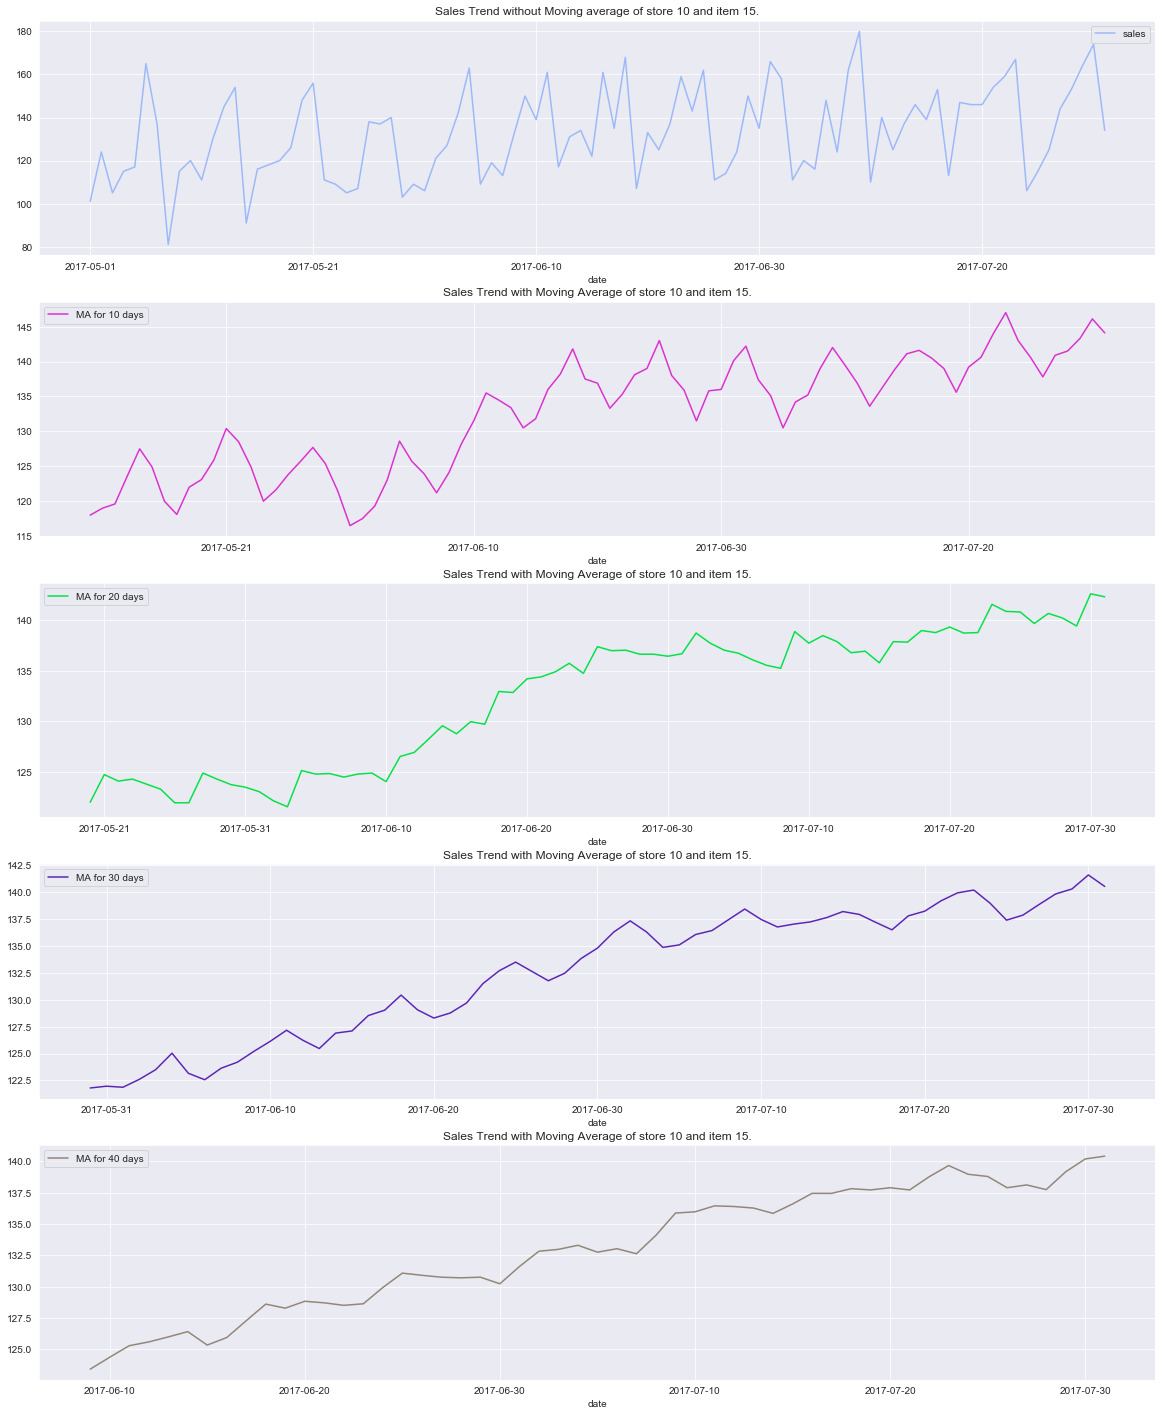

In [6]:
model.lineplot([10, 20, 30, 40])

From the MA plot above, there is a clear indication that their is a rise in the sales recorded in the 3 months. 

# AutoCorrelation plot 

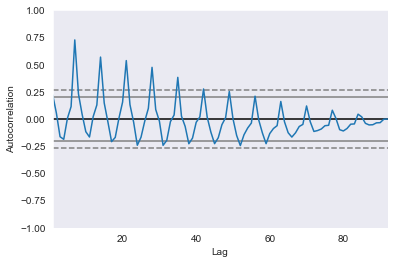

In [7]:
model.autocorr()

Autocorrelation plot showing P value to be between 4 and 6

# Kernel Density and Bar Plot of the percentage change in the daily returns

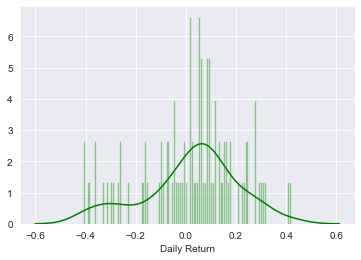

In [8]:
model.distplot()

# Partial Correlation Plot

Can help us to determine a suitable Moving Average value.

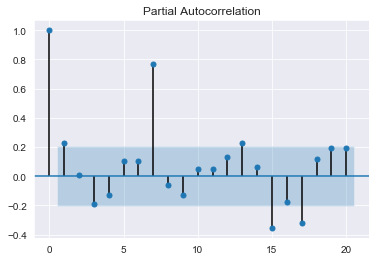

In [9]:
model.partialcorr(20)

From the graph above, 4 points are above the critical region. Below 4 could be tested for the model.

# Arima Model Summary

model order of 6, 1, 3 is tested

In [18]:
model.arima([6, 1, 3])

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                   91
Model:                 ARIMA(6, 1, 3)   Log Likelihood                -359.321
Method:                       css-mle   S.D. of innovations             11.996
Date:                Wed, 05 Aug 2020   AIC                            740.642
Time:                        13:23:16   BIC                            768.261
Sample:                    05-

# Residual Plot using the same order above.

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
AxesSubplot(0.125,0.125;0.775x0.755)
               0
count  91.000000
mean    0.726127
std    13.173005
min   -27.288621
25%    -8.437480
50%     1.785092
75%     8.688748
max    52.584321


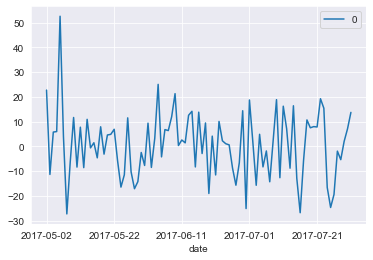

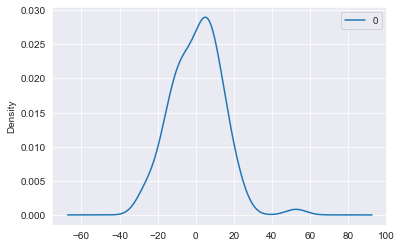

In [11]:
model.resid([6, 1, 3])

MSE of Test data = 247.36426144480424


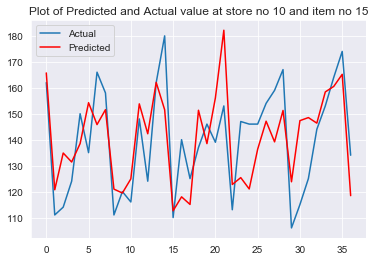

In [19]:
Predictions, Test = model.forcast(0.6, [6, 1, 3])

# Analysis on Store number 5 and item number 40 in 2017 from May till July

In [20]:
model_1 = TimeSeriesModel('train.csv', '2017-05', '2017-06', '2017-07', 5, 40)

In [21]:
model_1.dataframe().head()


,store,item,sales
date,,,
2017-05-01,5,40,18
2017-05-02,5,40,32
2017-05-03,5,40,25
2017-05-04,5,40,30
2017-05-05,5,40,33


A preview into the dataset with its first 5 values

# In plotting the chart, we plot 4 different MA values and the actual chart without moving average.

MA of 15, 25, 40 and 50 can be evaluated and tested.

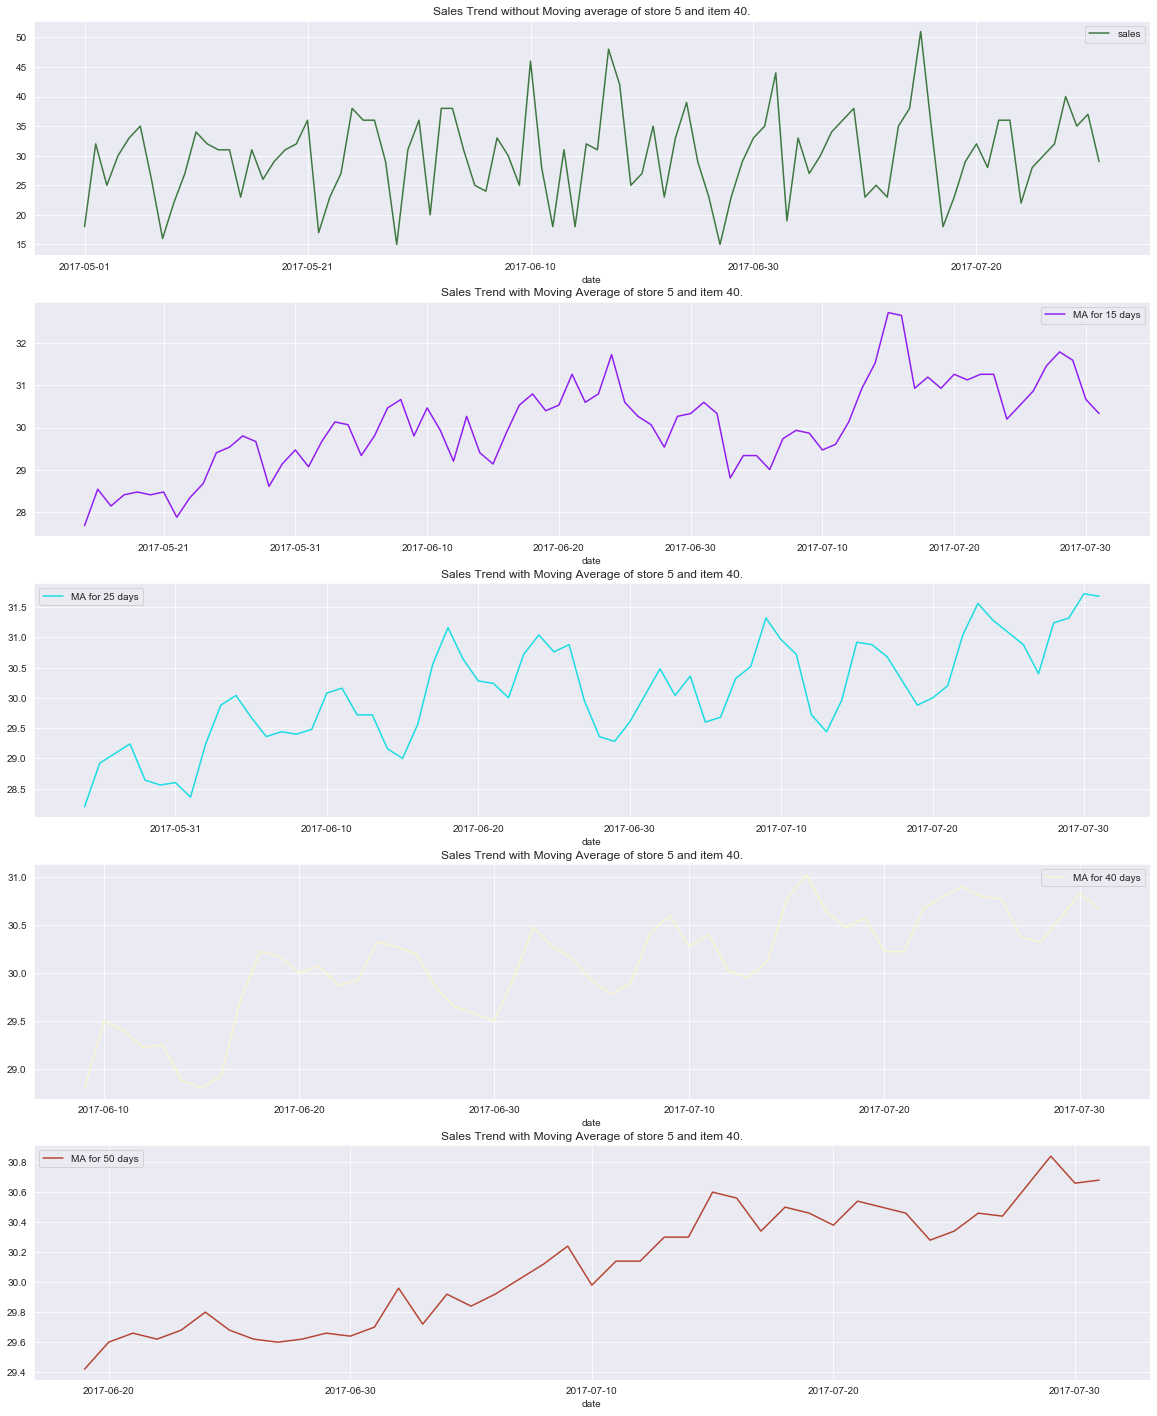

In [22]:
model_1.lineplot([15, 25, 40, 50])

From the MA plot above, there is a clear indication that there is a rise in the sales recorded in the 3 months.

# AutoCorrelation plot

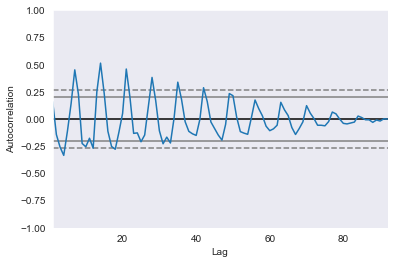

In [23]:
model_1.autocorr()

Autocorrelation plot showing P value to be between 5 and 6

# Kernel Density and Bar Plot of the percentage change in the daily returns

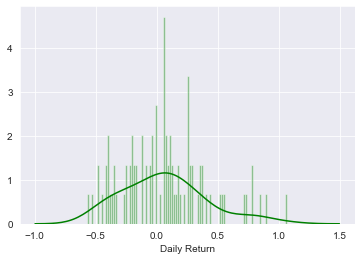

In [24]:
model_1.distplot()

# Partial Correlation Plot
Can help us to determine a suitable Moving Average value.

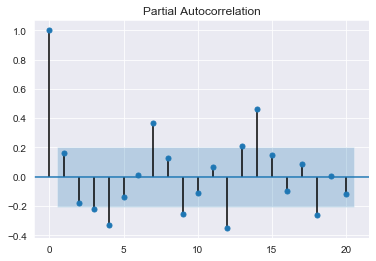

In [25]:
model_1.partialcorr(20)

From the graph above, 3 points are above the critical region. 1, 2 or 3 could be tested for the model

# Arima Model Summary

In [27]:
model_1.arima([6, 1, 0])

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                   91
Model:                 ARIMA(6, 1, 0)   Log Likelihood                -299.179
Method:                       css-mle   S.D. of innovations              6.367
Date:                Wed, 05 Aug 2020   AIC                            614.357
Time:                        13:27:05   BIC                            634.444
Sample:                    05-

model order of 6, 1, 3 is tested

# Residual Plot using the same order above.

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
AxesSubplot(0.125,0.125;0.775x0.755)
               0
count  91.000000
mean    0.243944
std     6.422338
min   -14.584656
25%    -3.452654
50%     0.473174
75%     3.509811
max    16.176506


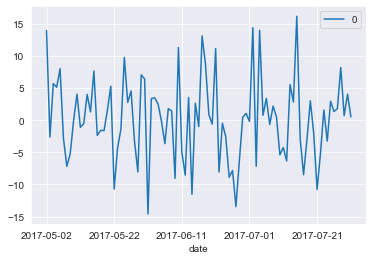

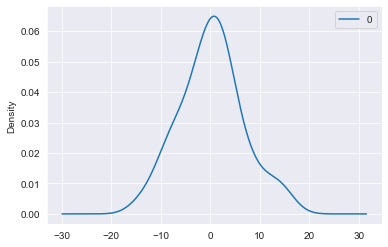

In [28]:
model_1.resid([6, 1, 1])

MSE of Test data = 47.27479067719607


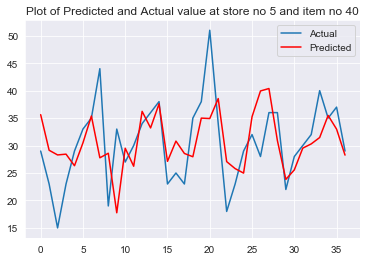

In [30]:
Predictions_1, Test_1 = model_1.forcast(0.6, [6, 1, 0])

# Analysis on Store number 1 and item number 30 in 2017 from October till December

In [31]:
model_2 = TimeSeriesModel('train.csv', '2017-10', '2017-11', '2017-12', 1, 30)

In [32]:
model_2.dataframe().head()

,store,item,sales
date,,,
2017-10-01,1,30,29
2017-10-02,1,30,19
2017-10-03,1,30,35
2017-10-04,1,30,35
2017-10-05,1,30,55


In [33]:
model_2.dataframe()[['store', 'item', 'sales']].describe()

,store,item,sales
count,92.0,92.0,92.000000
mean,1.0,30.0,38.271739
std,0.0,0.0,9.252387
min,1.0,30.0,19.000000
25%,1.0,30.0,31.000000
50%,1.0,30.0,38.000000
75%,1.0,30.0,44.000000
max,1.0,30.0,61.000000


A preview into the dataset with its first 5 values

# In plotting the chart, we plot 4 different MA values and the actual chart without moving average.
MA of 10, 20, 30 and 40 can be evaluated and tested.


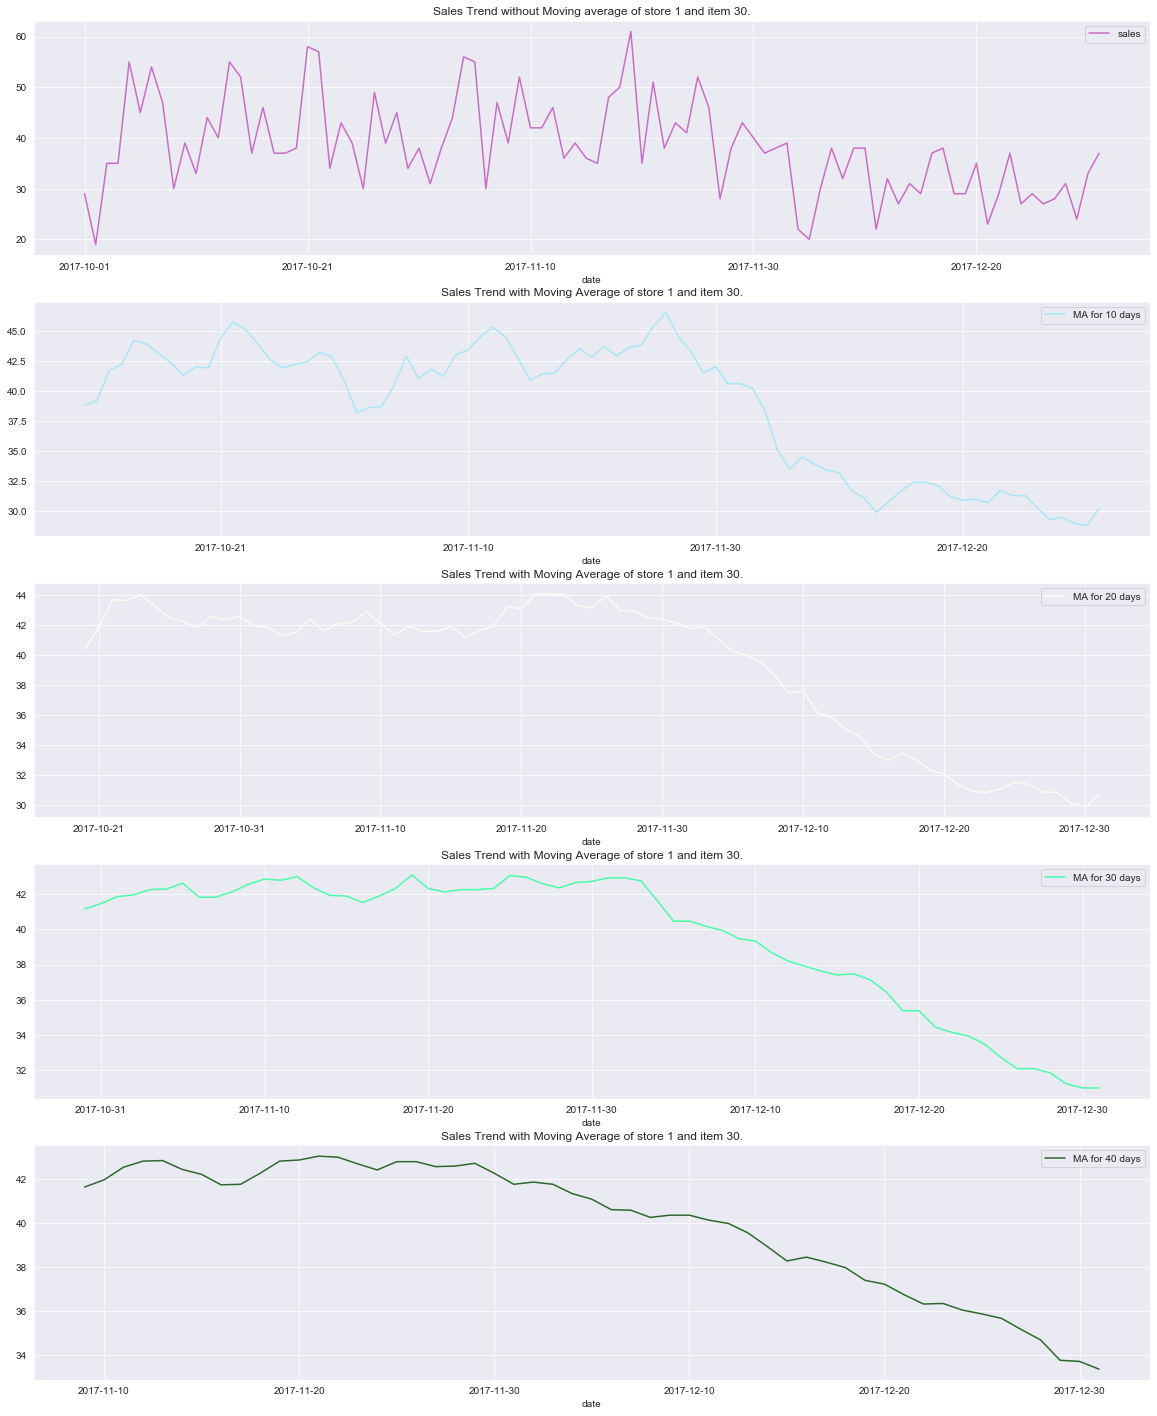

In [34]:
model_2.lineplot([10, 20, 30, 40])

From the MA plot above, there is a clear indication that there is a fall in the sales recorded in the 3 months.


# AutoCorrelation plot

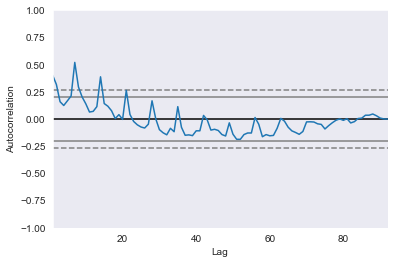

In [35]:
model_2.autocorr()

Autocorrelation plot showing P value to be between 1 and 3

# Kernel Density and Bar Plot of the percentage change in the daily returns

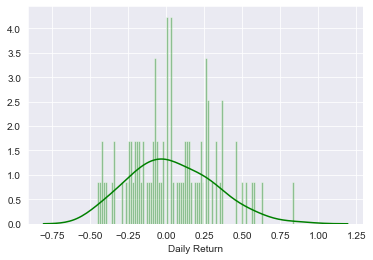

In [36]:
model_2.distplot()

# Partial Correlation Plot

Can help us to determine a suitable Moving Average value.


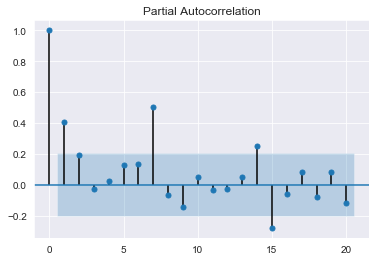

In [37]:
model_2.partialcorr(20)

From the graph above, 4 points are above the critical region. Below 4 could be tested for the model.

# Arima Model Summary


model order of 3, 2, 1 is tested

In [39]:
model_1.arima([3, 2, 1])

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
                             ARIMA Model Results                              
Dep. Variable:               D2.sales   No. Observations:                   90
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -323.611
Method:                       css-mle   S.D. of innovations              8.527
Date:                Wed, 05 Aug 2020   AIC                            659.221
Time:                        13:28:08   BIC                            674.220
Sample:                    05-

Residual Plot using the same order above.

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
AxesSubplot(0.125,0.125;0.775x0.755)
               0
count  90.000000
mean   -0.568009
std     8.904381
min   -20.996801
25%    -6.462122
50%     1.084836
75%     5.430929
max    19.351197


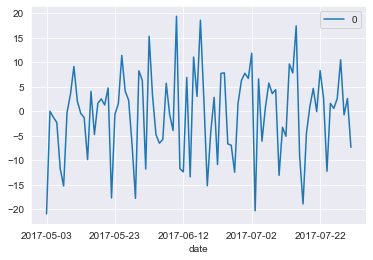

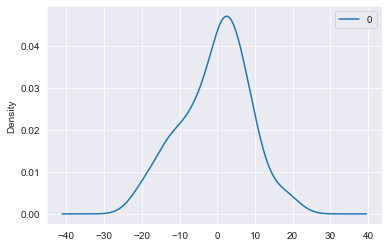

In [40]:
model_1.resid([3, 2, 1])

MSE of Test data = 54.91046573553913


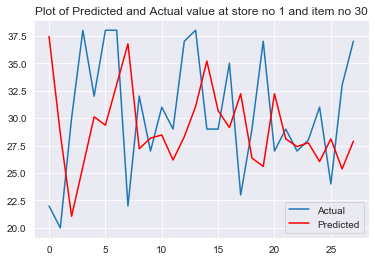

In [42]:
Pred1, Test1 = model_2.forcast(0.7, [3, 2, 1])

# Conclusion 

From the graphs of the predictions and actual values obtained above, the model can be said to have performed above average but not excellently yet. 

Further tunning of the model order can be adopted or using an entirely different model to analyze for better performance